In [1219]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

In [1091]:
emb_dim=100

In [1343]:
def load_facts(filename):
    facts=[]
    for line in open(filename):
        line=line.strip().split(',')
        fact=[]
        if line[0]=='not':
            fact.append(True)
            line=line[1:]
        else:
            fact.append(False)
        fact.append(line[0])
        fact.append(line[1:])
        facts.append([fact])
    return facts

In [1456]:
def load_knowledge(filename):
    knowledges=[]
    for line in open(filename):
        line=line.strip().split('|')
        condition=[]
        for c in line[0].strip().split(','):
            c=c.strip().split(' ')
            condition.append(c)
        clause=[]
        for predicate in line[1:]:
            predicate=predicate.strip().split(',')
            if predicate[0]=='not':
                predicate=[True,predicate[1],predicate[2:]]
            else:
                predicate=[False,predicate[0],predicate[1:]]
            clause.append(predicate)
        knowledges.append([condition,clause])
    return knowledges

In [1457]:
def construct_training(clauses, variable, for_all, constants='abcdefghijklmn'):
    new_clauses=[]
    if for_all:
        for clause in clauses:
            new_clauses+=replace_clause(clause,variable,constants)
    else:
        for clause in clauses:
            disjunction=[]
            for clause in replace_clause(clause,variable,constants):
                disjunction+=clause
            new_clauses.append(disjunction)
    return new_clauses

def replace_clause(clause,variable,constants):
    new_clauses=[]
    for constant in constants:
        new_clause=copy.deepcopy(clause)
        for i in range(len(new_clause)):
            for j in range(len(new_clause[i][2])):
                if new_clause[i][2][j]==variable:
                    new_clause[i][2][j]=constant
        new_clauses.append(new_clause)
    return new_clauses

In [1458]:
def construct_fact_from_knowledge(knowledges, constants):
    facts=[]
    for knowledge in knowledges:
        clause=[knowledge[1]]
        for c in knowledge[0]:
            if c[0]=='all':
                clause=construct_training(clause,variable=c[1],for_all=True, constants=constants)
            else:
                clause=construct_training(clause,variable=c[1],for_all=False, constants=constants)
        facts+=clause
    return facts

In [1459]:
def show_results(facts):
    wrong=0
    for f in facts:
        output=ltn.forward(clause=f)
        if output[1].data.numpy()[0]>0.95:
            continue
        print(f)
        print(output[1].data.numpy()[0])
        wrong+=1
    print(wrong)

In [1466]:
class Constants(nn.Module):
    def __init__(self, constants,emb_dim):
        super(Constants, self).__init__()
        self.symbol2id=dict()
        self.id2symbol=dict()
        for i,s in enumerate(constants):
            self.symbol2id[s]=i
            self.id2symbol[i]=s
        self.embeddings = nn.Embedding(len(self.symbol2id), emb_dim)
    def forward(self,constants):
        constant_id=[]
        for c in constants:
            constant_id.append(self.symbol2id[c])
        embs=self.embeddings(Variable(torch.LongTensor(constant_id)))
        embs=torch.cat(embs).view(1,-1)
        return embs

In [1467]:
class Predicate(nn.Module):
    def __init__(self, name, variable_count, emb_dim):
        super(Predicate, self).__init__()
        self.name=name
        self.variable_count=variable_count
        self.emb_dim=emb_dim
        m=variable_count*emb_dim
        self.variable_count=variable_count
        self.W=Variable(torch.randn(m, emb_dim, m), requires_grad=True)
        self.V=Variable(torch.randn(m, emb_dim), requires_grad=True)
        self.B=Variable(torch.randn(emb_dim), requires_grad=True)
        self.u=Variable(torch.randn(emb_dim), requires_grad=True)
    def forward(self, embs, negation):
        m=self.variable_count*self.emb_dim
        W=self.W.view(m,-1)
        output=torch.mm(embs,W)
        output=output.view(-1,m)
        output=torch.mm(output,embs.view(-1,1))
        output=output.view(1,-1)
        output=output.add(torch.mm(embs,self.V))
        output=output.add(self.B)
        output=output.view(-1)
        output=torch.tanh(output)
        output=torch.mul(output,self.u).sum()
        output=torch.sigmoid(output)
        if negation:
            output=1.0-output
        return output

In [1468]:
class LTN(nn.Module):
    def __init__(self, emb_dim, constants, predicates):
        super(LTN2, self).__init__()
        self.emb_dim=emb_dim
        self.Constants=Constants(constants, emb_dim)
        self.Predicates=dict()
        for name,n in predicates:
            self.Predicates[name]=Predicate(name,n,emb_dim)
    def forward(self, clause):
        predicate_results=[]
        Ans=None
        for predicate in clause:
            negation=predicate[0]
            name=predicate[1]
            constants=predicate[2]
            embs=self.Constants.forward(constants)
            output=self.Predicates[name].forward(embs,negation)
            predicate_results.append(output)
            if Ans is None or Ans.data.numpy()[0]<output.data.numpy()[0]:
                Ans=output
        return torch.log(Ans),Ans
    def parameters(self):
        results=list(self.Constants.parameters())
        for name in self.Predicates:
            results+=list(self.Predicates[name].parameters())
        return results

In [1469]:
facts1=load_facts('./facts1.txt')
facts2=load_facts('./facts2.txt')
knowledges=load_knowledge('./knowledge.txt')
facts3=construct_fact_from_knowledge(knowledges,constants='abcdefgh')
facts4=construct_fact_from_knowledge(knowledges,constants='ijklmn')
facts=facts1+facts2+facts3

  0%|          | 0/2000 [00:00<?, ?it/s]

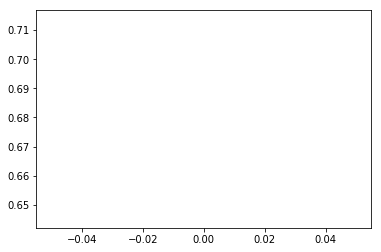

[[False, 'S', ['a']]]
4.6943e-06
[[False, 'S', ['e']]]
9.61608e-05
[[False, 'S', ['f']]]
0.00139817
[[True, 'S', ['b']]]
0.846042
[[True, 'S', ['c']]]
1.94311e-05
[[True, 'S', ['g']]]
0.000254929
[[True, 'S', ['h']]]
0.0116063
[[False, 'F', ['a', 'b']]]
0.000145003
[[False, 'F', ['c', 'd']]]
0.00060148
[[False, 'F', ['e', 'f']]]
0.0047983
[[False, 'F', ['g', 'h']]]
0.00191976
[[True, 'F', ['a', 'c']]]
0.000135422
[[True, 'F', ['a', 'd']]]
0.00905585
[[True, 'F', ['a', 'h']]]
0.266914
[[True, 'F', ['b', 'd']]]
5.71012e-05
[[True, 'F', ['b', 'e']]]
0.0263224
[[True, 'F', ['b', 'f']]]
0.00256664
[[True, 'F', ['b', 'g']]]
0.0
[[True, 'F', ['c', 'e']]]
6.48499e-05
[[True, 'F', ['c', 'g']]]
0.411584
[[True, 'F', ['c', 'h']]]
0.628495
[[True, 'F', ['d', 'e']]]
0.0146568
[[True, 'F', ['d', 'f']]]
0.924848
[[True, 'F', ['d', 'g']]]
0.00612527
[[False, 'C', ['a']]]
0.0194467
[[False, 'C', ['e']]]
0.000718371
[[True, 'C', ['b']]]
0.0
[[True, 'C', ['c']]]
0.618793
[[True, 'C', ['f']]]
0.00103116
[

  0%|          | 1/2000 [00:03<2:09:51,  3.90s/it]


0.0116063
[[True, 'S', ['h']], [True, 'F', ['h', 'b']], [False, 'S', ['b']]]
0.153959
[[True, 'S', ['h']], [True, 'F', ['h', 'd']], [False, 'S', ['d']]]
0.0204971
[[True, 'S', ['h']], [True, 'F', ['h', 'e']], [False, 'S', ['e']]]
0.0116063
[[True, 'S', ['h']], [True, 'F', ['h', 'f']], [False, 'S', ['f']]]
0.0116063
[[True, 'S', ['c']], [False, 'C', ['c']]]
0.381207
[[True, 'S', ['g']], [False, 'C', ['g']]]
0.000254929
[[True, 'S', ['h']], [False, 'C', ['h']]]
0.901982
87


  5%|▌         | 100/2000 [04:37<1:28:01,  2.78s/it]

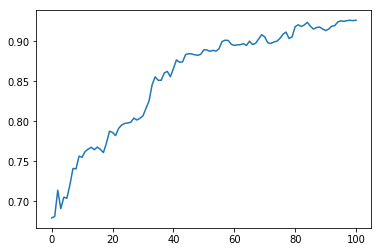

[[False, 'S', ['a']]]
1.6383e-05
[[False, 'S', ['e']]]
0.00558976
[[False, 'S', ['f']]]
0.041533
[[False, 'S', ['g']]]
7.27739e-07
[[False, 'F', ['a', 'e']]]
0.910461
[[False, 'F', ['a', 'f']]]
0.170064
[[False, 'F', ['c', 'd']]]
3.85153e-05
[[False, 'F', ['e', 'f']]]
0.00161628
[[False, 'F', ['g', 'h']]]
0.88201
[[True, 'F', ['b', 'g']]]
0.0917892
[[True, 'F', ['e', 'e']]]
3.69549e-06
[[True, 'F', ['g', 'g']]]
0.00569808
[[True, 'F', ['a', 'b']], [False, 'F', ['b', 'a']]]
0.00593908
[[True, 'F', ['a', 'e']], [False, 'F', ['e', 'a']]]
0.0895386
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.829936
[[True, 'F', ['c', 'b']], [False, 'F', ['b', 'c']]]
0.744431
[[True, 'F', ['g', 'b']], [False, 'F', ['b', 'g']]]
0.908211
[[True, 'F', ['g', 'd']], [False, 'F', ['d', 'g']]]
0.487044
[[True, 'F', ['h', 'g']], [False, 'F', ['g', 'h']]]
0.88201
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', [

  5%|▌         | 101/2000 [04:41<1:28:16,  2.79s/it]

23


 10%|█         | 200/2000 [09:30<1:25:36,  2.85s/it]

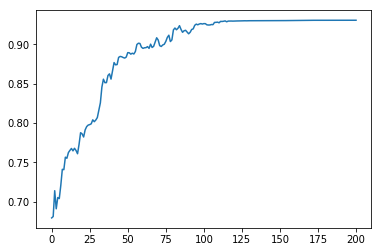

[[False, 'S', ['a']]]
7.88915e-05
[[False, 'S', ['e']]]
3.51398e-05
[[False, 'S', ['f']]]
0.472353
[[False, 'S', ['g']]]
6.03533e-07
[[False, 'F', ['a', 'b']]]
0.0363996
[[False, 'F', ['a', 'e']]]
0.00736419
[[False, 'F', ['c', 'd']]]
1.24301e-06
[[False, 'F', ['e', 'f']]]
1.43235e-06
[[True, 'F', ['b', 'g']]]
0.000311255
[[True, 'F', ['e', 'e']]]
8.34465e-07
[[True, 'F', ['g', 'g']]]
0.000712335
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.00221348
[[False, 'F', ['c', 'a']], [False, 'F', ['c', 'b']], [False, 'F', ['c', 'c']], [False, 'F', ['c', 'd']], [False, 'F', ['c', 'e']], [False, 'F', ['c', 'f']], [False, 'F', ['c', 'g']], [False, 'F', ['c', 'h']]]
0.00530065
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
0.000633177
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f'

 10%|█         | 201/2000 [09:35<1:25:50,  2.86s/it]

[[True, 'S', ['f']], [False, 'C', ['f']]]
0.527647
16


 15%|█▌        | 300/2000 [14:44<1:23:33,  2.95s/it]

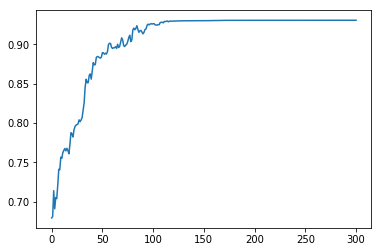

[[False, 'S', ['a']]]
1.32149e-05
[[False, 'S', ['e']]]
0.000348373
[[False, 'S', ['f']]]
0.426671
[[False, 'S', ['g']]]
3.00902e-09
[[False, 'F', ['a', 'b']]]
0.000439965
[[False, 'F', ['a', 'e']]]
0.00245821
[[False, 'F', ['a', 'f']]]
0.934413
[[False, 'F', ['c', 'd']]]
7.22235e-05
[[False, 'F', ['e', 'f']]]
3.57724e-05
[[True, 'F', ['b', 'g']]]
0.000267684
[[True, 'F', ['e', 'e']]]
3.48091e-05
[[True, 'F', ['g', 'g']]]
0.0924598
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.065587
[[True, 'F', ['g', 'g']], [False, 'F', ['g', 'g']]]
0.90754
[[False, 'F', ['c', 'a']], [False, 'F', ['c', 'b']], [False, 'F', ['c', 'c']], [False, 'F', ['c', 'd']], [False, 'F', ['c', 'e']], [False, 'F', ['c', 'f']], [False, 'F', ['c', 'g']], [False, 'F', ['c', 'h']]]
0.000254675
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
0.000373681
[

 15%|█▌        | 301/2000 [14:48<1:23:35,  2.95s/it]

[[True, 'S', ['f']], [False, 'C', ['f']]]
0.573329
18


 20%|██        | 400/2000 [19:37<1:18:31,  2.94s/it]

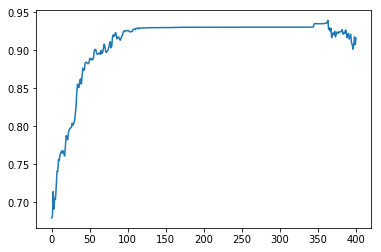

[[False, 'S', ['g']]]
0.00010243
[[False, 'F', ['a', 'b']]]
0.00792623
[[False, 'F', ['a', 'e']]]
9.95396e-06
[[False, 'F', ['a', 'f']]]
0.0431327
[[False, 'F', ['c', 'd']]]
0.416464
[[False, 'F', ['e', 'f']]]
6.73131e-08
[[True, 'F', ['a', 'c']]]
0.817809
[[True, 'F', ['b', 'g']]]
0.0210524
[[False, 'C', ['a']]]
0.00669361
[[True, 'C', ['f']]]
0.00232679
[[True, 'C', ['g']]]
0.0322184
[[True, 'F', ['g', 'g']]]
0.000481486
[[True, 'F', ['a', 'c']], [False, 'F', ['c', 'a']]]
0.817809
[[True, 'F', ['c', 'a']], [False, 'F', ['a', 'c']]]
0.623346
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.583536
[[True, 'F', ['g', 'f']], [False, 'F', ['f', 'g']]]
0.0441189
[[False, 'F', ['c', 'a']], [False, 'F', ['c', 'b']], [False, 'F', ['c', 'c']], [False, 'F', ['c', 'd']], [False, 'F', ['c', 'e']], [False, 'F', ['c', 'f']], [False, 'F', ['c', 'g']], [False, 'F', ['c', 'h']]]
0.416464
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [Fals

 20%|██        | 401/2000 [19:41<1:18:30,  2.95s/it]

[[True, 'S', ['a']], [False, 'C', ['a']]]
0.00669361
23


 25%|██▌       | 500/2000 [24:35<1:13:47,  2.95s/it]

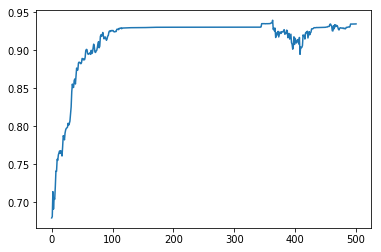

[[False, 'S', ['a']]]
0.0289382
[[False, 'S', ['g']]]
5.08433e-11
[[False, 'F', ['a', 'b']]]
5.94822e-12
[[False, 'F', ['a', 'e']]]
1.59119e-08
[[False, 'F', ['a', 'g']]]
0.00249976
[[False, 'F', ['e', 'f']]]
0.00270202
[[False, 'C', ['a']]]
4.06431e-06
[[True, 'C', ['f']]]
2.38419e-07
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000108361
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
4.48227e-05
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
0.000449179
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
0.0220889
[[False, 'F', ['e', 'a']], [False, 'F', ['e', 'b']], [False, 'F', ['e', 'c']], [False, 'F', ['e', 'd']], [False, 'F', ['e', 'e']], [False, 'F', [

 25%|██▌       | 501/2000 [24:39<1:13:47,  2.95s/it]

14


 30%|███       | 600/2000 [29:42<1:09:19,  2.97s/it]

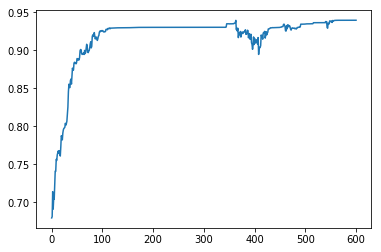

[[False, 'S', ['a']]]
0.0113635
[[False, 'S', ['g']]]
2.00866e-11
[[False, 'F', ['a', 'b']]]
7.17056e-11
[[False, 'F', ['a', 'e']]]
3.90246e-07
[[False, 'F', ['a', 'g']]]
1.43105e-06
[[False, 'C', ['a']]]
2.33775e-05
[[True, 'C', ['f']]]
0.000250757
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000168204
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000117302
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.000260174
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
0.000279996
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
0.000807931
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F'

 30%|███       | 601/2000 [29:48<1:09:23,  2.98s/it]

13


 35%|███▌      | 700/2000 [34:37<1:04:18,  2.97s/it]

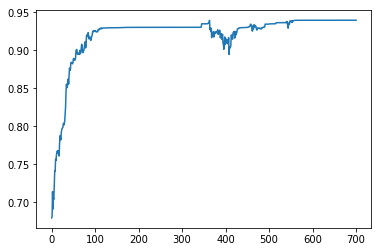

[[False, 'S', ['a']]]
0.726306
[[False, 'S', ['g']]]
8.9028e-09
[[False, 'F', ['a', 'b']]]
7.23624e-14
[[False, 'F', ['a', 'e']]]
5.07333e-07
[[False, 'F', ['a', 'g']]]
1.54186e-06
[[False, 'C', ['a']]]
0.00014744
[[True, 'C', ['f']]]
4.27961e-05
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000255287
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000215948
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
5.00679e-06
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
4.4316e-05
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
9.8185e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f

 35%|███▌      | 701/2000 [34:41<1:04:17,  2.97s/it]

[[True, 'S', ['a']], [False, 'C', ['a']]]
0.273694
14


 40%|████      | 800/2000 [39:17<58:56,  2.95s/it]  

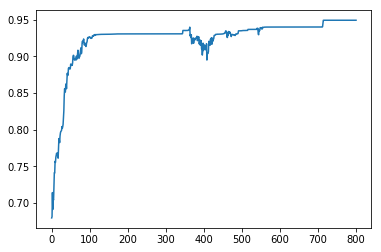

[[False, 'S', ['g']]]
1.56842e-09
[[False, 'F', ['a', 'b']]]
2.69724e-09
[[False, 'F', ['a', 'e']]]
4.52193e-08
[[False, 'F', ['a', 'g']]]
3.12779e-05
[[True, 'C', ['f']]]
0.00081414
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000363827
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000183642
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.00014019
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
0.0130919
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
4.80773e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f', 'e']], [False, 'F', ['f', 'f']], [False, 'F', ['f', 'g']], [Fa

 40%|████      | 801/2000 [39:21<58:54,  2.95s/it]

11


 45%|████▌     | 900/2000 [44:04<53:52,  2.94s/it]

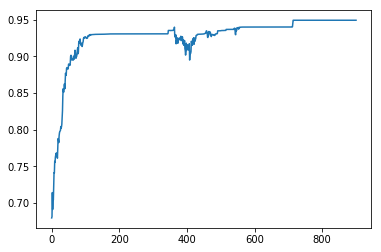

[[False, 'S', ['g']]]
1.40489e-06
[[False, 'F', ['a', 'b']]]
2.0957e-05
[[False, 'F', ['a', 'e']]]
2.2317e-05
[[False, 'F', ['a', 'g']]]
4.21276e-05
[[True, 'C', ['f']]]
0.26876
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000208795
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000396192
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.000217378
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
0.000273247
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
5.06046e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f', 'e']], [False, 'F', ['f', 'f']], [False, 'F', ['f', 'g']], [Fals

 45%|████▌     | 901/2000 [44:08<53:50,  2.94s/it]

[[True, 'S', ['f']], [False, 'C', ['f']]]
0.73124
12


 50%|█████     | 1000/2000 [48:51<48:51,  2.93s/it]

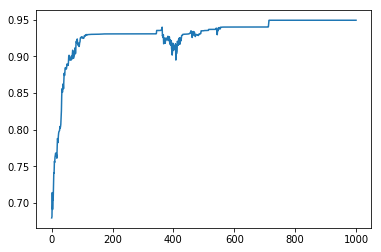

[[False, 'S', ['g']]]
8.50818e-05
[[False, 'F', ['a', 'b']]]
1.12748e-05
[[False, 'F', ['a', 'e']]]
1.78132e-05
[[False, 'F', ['a', 'g']]]
3.96059e-05
[[True, 'C', ['f']]]
0.922118
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000262558
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000473619
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.000243723
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
4.41205e-05
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
3.30372e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f', 'e']], [False, 'F', ['f', 'f']], [False, 'F', ['f', 'g']], [F

 50%|█████     | 1001/2000 [48:55<48:49,  2.93s/it]

[[True, 'S', ['f']], [False, 'C', ['f']]]
0.0778815
12


 55%|█████▌    | 1100/2000 [53:41<43:55,  2.93s/it]

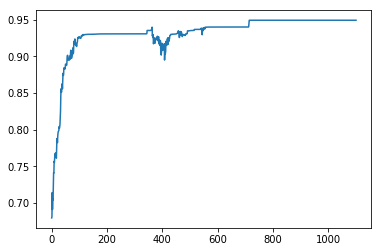

[[False, 'S', ['g']]]
8.51672e-05
[[False, 'F', ['a', 'b']]]
1.12575e-05
[[False, 'F', ['a', 'e']]]
1.71817e-05
[[False, 'F', ['a', 'g']]]
5.03181e-05
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000235975
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000449955
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.000226557
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
3.75572e-05
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
2.46868e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f', 'e']], [False, 'F', ['f', 'f']], [False, 'F', ['f', 'g']], [False, 'F', ['f', 'h']]]

 55%|█████▌    | 1101/2000 [53:45<43:53,  2.93s/it]


8.39057e-05
[[True, 'S', ['f']], [False, 'C', ['f']]]
0.011164
11


 60%|██████    | 1200/2000 [59:01<39:21,  2.95s/it]

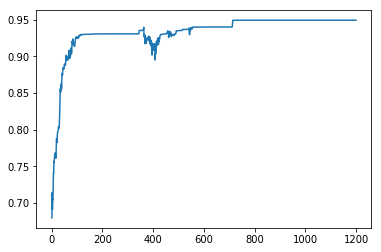

[[False, 'S', ['g']]]
8.19643e-05
[[False, 'F', ['a', 'b']]]
1.03324e-05
[[False, 'F', ['a', 'e']]]
1.48715e-05
[[False, 'F', ['a', 'g']]]
5.13764e-05
[[True, 'F', ['a', 'f']], [False, 'F', ['f', 'a']]]
0.000218451
[[True, 'F', ['c', 'd']], [False, 'F', ['d', 'c']]]
0.000424445
[[True, 'F', ['e', 'f']], [False, 'F', ['f', 'e']]]
0.000222385
[[False, 'F', ['b', 'a']], [False, 'F', ['b', 'b']], [False, 'F', ['b', 'c']], [False, 'F', ['b', 'd']], [False, 'F', ['b', 'e']], [False, 'F', ['b', 'f']], [False, 'F', ['b', 'g']], [False, 'F', ['b', 'h']]]
3.62402e-05
[[False, 'F', ['d', 'a']], [False, 'F', ['d', 'b']], [False, 'F', ['d', 'c']], [False, 'F', ['d', 'd']], [False, 'F', ['d', 'e']], [False, 'F', ['d', 'f']], [False, 'F', ['d', 'g']], [False, 'F', ['d', 'h']]]
2.90167e-05
[[False, 'F', ['f', 'a']], [False, 'F', ['f', 'b']], [False, 'F', ['f', 'c']], [False, 'F', ['f', 'd']], [False, 'F', ['f', 'e']], [False, 'F', ['f', 'f']], [False, 'F', ['f', 'g']], [False, 'F', ['f', 'h']]]
8.3387

 60%|██████    | 1201/2000 [59:06<39:19,  2.95s/it]

[[True, 'S', ['f']], [False, 'C', ['f']]]
0.00429967
11


 64%|██████▎   | 1270/2000 [1:03:24<36:26,  3.00s/it]

KeyboardInterrupt: 

In [1471]:
ltn=LTN2(emb_dim,'abcdefghijklmn',[['S',1],['F',2],['C',1]])
optimizor=torch.optim.Adam(ltn.parameters(),lr=0.1,weight_decay=0.1)
mone=torch.FloatTensor([-1])
errs=[]
for i in tqdm(range(2000)):
    optimizor.zero_grad()
    total_probability=0
    for f in facts:
        log,prob=ltn.forward(clause=f)
        prob.backward(mone)
        total_probability+=prob.data.numpy()[0]
    optimizor.step()
    errs.append(total_probability/len(facts))
    if i%100==0:
        plt.plot(errs)
        plt.show()
        show_results(facts)

In [1339]:
show_results(facts)

[False, 'S', ['g']]
0.00163262
1


In [1445]:
ltn.forward(clause=[[True,'C',['f']]])

(Variable containing:
 1.00000e-04 *
  -1.0580
 [torch.FloatTensor of size 1], Variable containing:
  0.9999
 [torch.FloatTensor of size 1])

In [1446]:
ltn.forward(clause=[[False,'S',['f']]])

(Variable containing:
 1.00000e-04 *
  -1.6870
 [torch.FloatTensor of size 1], Variable containing:
  0.9998
 [torch.FloatTensor of size 1])

In [1448]:
ltn.forward(clause=[[True,'S',['f']],[False,'C',['f']]])

(Variable containing:
 -8.6875
 [torch.FloatTensor of size 1], Variable containing:
 1.00000e-04 *
   1.6868
 [torch.FloatTensor of size 1])

In [1465]:
[[True,'S',['f']],[False,'C',['f']]] in facts

True

In [1453]:
knowledges[-1]

[[['all', 'x']], [[True, 'S', ['x']], [True, 'C', ['x']]]]

In [1464]:
construct_fact_from_knowledge(knowledges[-1:],constants='abcdefgh')

[[[True, 'S', ['a']], [False, 'C', ['a']]],
 [[True, 'S', ['b']], [False, 'C', ['b']]],
 [[True, 'S', ['c']], [False, 'C', ['c']]],
 [[True, 'S', ['d']], [False, 'C', ['d']]],
 [[True, 'S', ['e']], [False, 'C', ['e']]],
 [[True, 'S', ['f']], [False, 'C', ['f']]],
 [[True, 'S', ['g']], [False, 'C', ['g']]],
 [[True, 'S', ['h']], [False, 'C', ['h']]]]